In [48]:
import sys
sys.path.append('/Users/demos/PycharmProjects/deloitte_hack/')
#import seaborn as sns 

import dataCrush as dc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from os import listdir
import plotly as pl
from sklearn.ensemble import RandomForestRegressor

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['f', 'test']
`%matplotlib` prevents importing * from pylab and numpy



## exploration:
using NGO_DataDisbursement, we explore the expenditure of the NGO for each policy for all regions. Mean values are shown.

In [53]:
dc.printDiseasePerCountry()

-> Top expenditure per desease per region <-
----
(disease -> Measles-Rubella)  --- (Region -> EMRO) --- (expenditure = 319.0 USD Mi.)
(disease -> Rotavirus)  --- (Region -> EURO) --- (expenditure = 187.2 USD Mi.)
(disease -> Measles)  --- (Region -> CENTRAL AFRICA) --- (expenditure = 164.5 USD Mi.)
(disease -> IPV)  --- (Region -> SEARO) --- (expenditure = 187.7 USD Mi.)
(disease -> Ebola EPI Recovery Plan)  --- (Region -> WEST AFRICA) --- (expenditure = 201.6 USD Mi.)
(disease -> HPV)  --- (Region -> PAHO) --- (expenditure = 148.8 USD Mi.)
(disease -> Measles-Rubella)  --- (Region -> WPRO) --- (expenditure = 227.0 USD Mi.)
(disease -> Measles)  --- (Region -> SOUTH AFRICA) --- (expenditure = 282.0 USD Mi.)
(disease -> HPV)  --- (Region -> EAST AFRICA) --- (expenditure = 255.3 USD Mi.)


### Xplore further and get nice visualization as a funtion of time 

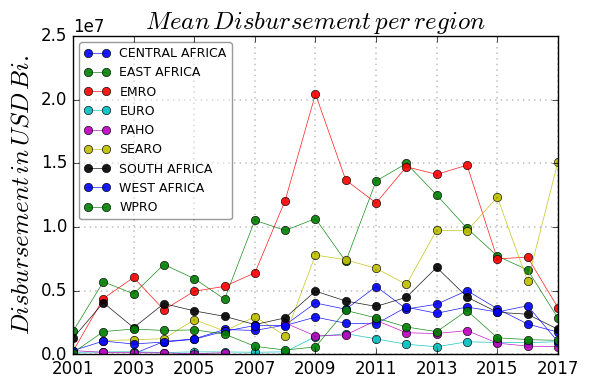

In [78]:
dc = reload(dc)
gd = dc.plotMeanDisbusementPerRegion(savePdf=True)

# Evolution of expenditure and relationship with coverage

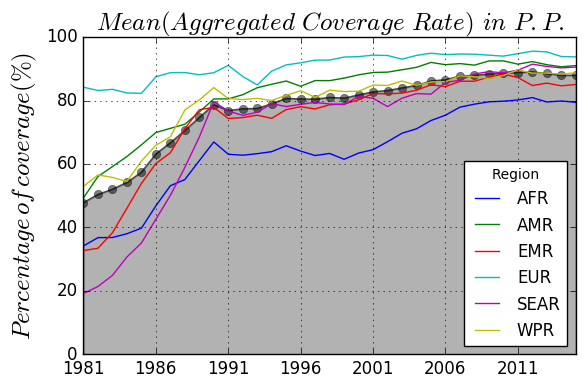

In [80]:
dc = reload(dc)
aggData = dc.computeAndPlotAggCoveragePerRegion(year='2015', vaccine='DTP3')


## Predicting the coverage gap for 2016 and 2017

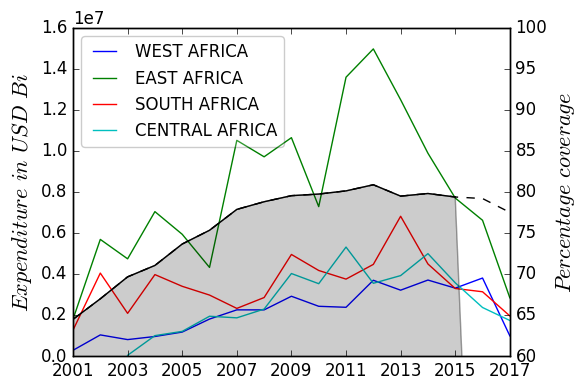

In [83]:
dc = reload(dc)
dc.predictCovRatioForAfricanCountries(gd, aggData)

# Coverage rate per vacinne 

In [12]:
dc = reload(dc)
R = dc.CoverageRatePerVaccine(year='2014')
R

,AFR,AMR,EMR,EUR,SEAR,WPR
DTP1,87.234043,95.800000,88.952381,96.415094,94.000000,94.185185
DTP3,79.425532,91.000000,85.047619,93.735849,90.545455,88.740741
HepB_BD,79.857143,72.647059,77.800000,93.727273,83.400000,84.318182
HepB3,79.659574,89.428571,84.952381,91.466667,90.545455,88.423077
Hib3,79.425532,90.057143,85.047619,92.096154,85.500000,86.615385
IPV1,33.526316,40.588235,75.785714,87.625000,46.714286,38.428571
Pol3,79.617021,90.800000,85.285714,93.924528,90.636364,89.000000
MCV1,77.404255,92.885714,83.285714,92.603774,88.818182,88.037037
MCV2,64.565217,84.357143,80.900000,91.120000,88.000000,85.000000
PCV3,74.305556,84.291667,84.461538,84.689655,40.500000,75.062500


## OLS

In [13]:
# Select a dataset
val = 'Death rate, crude (per 1,000 people).xls'
data = pd.read_excel('data/'+val)

# Select a dataset
val2 = 'WHO_Coverage_estimates.csv'
dataF = pd.read_csv('data/'+val2)

In [14]:
rg = data[['Country Name','2003']]

In [15]:
rg.sort_values(rg.columns[1],ascending=False).head(10)

,Country Name,2003
207,Sierra Leone,21.166
263,Zimbabwe,19.458
32,Central African Republic,18.999
139,Lesotho,18.591
3,Angola,17.574
226,Chad,17.462
39,Cote d'Ivoire,16.932
172,Nigeria,16.757
166,Malawi,16.532
199,Russian Federation,16.400


In [16]:
africanCountries = dataF[dataF['Region'] == 'AFR'].Cname.values
africanCountries[0:3]

array(['Algeria', 'Angola', 'Benin'], dtype=object)

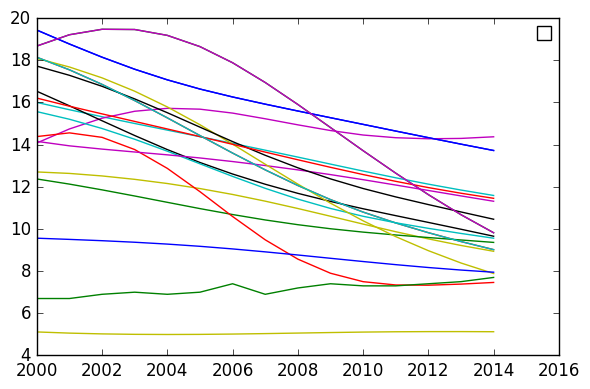

In [17]:
africanCountries = ['Angola','Zimbabwe', 'Zambia',
                   'South Sudan', 'Swaziland', 'Togo', 'Uganda',
                    'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
                   'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique',
                   'United Republic of Tanzania', 'Zambia', 'Zimbabwe', 'Algeria']
#africanCountries = dataF[dataF['Region'] == 'AFR'].Cname.values

DF = pd.DataFrame()
f,ax = plt.subplots(1,1,figsize=(6,4))
for i in range(len(africanCountries)):
    try:
        aggdt = data[data[data.columns[0]] == africanCountries[i]].T
        aggdt['2000':].plot(ax=ax)
        DF = pd.concat([DF, aggdt['2000':]],axis=1)
        plt.legend('')
    except:
        pass
    
DF = DF.mean(axis=1)
plt.tight_layout()

DF1 = DF.copy() 
DF = DF['2003':'2014']

# Predicting the Death ratio for the African continent 

In [26]:
x_train = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]['2003':'2014']
x_train = x_train.values
x_test = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]['2014':'2016'].values

In [41]:
labels = DF['2003':'2015'].values
test = pd.DataFrame(x_train)
test['4'] = labels 
test = test.values

In [43]:
# PREDICT VALUES USING SKLEARN
model2 = RandomForestRegressor(max_depth=300)
model2.fit(x_train, labels)
pred = model2.predict(x_test)

DF = pd.DataFrame(DF)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [45]:
DF1['2015'] = pred[0]
DF1['2016'] = pred[1]
DF1['2017'] = pred[2]

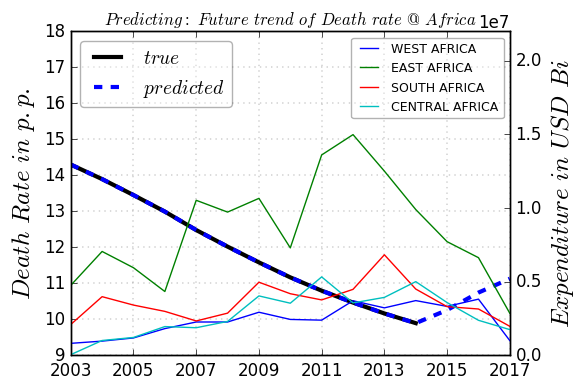

In [47]:
ttt = gd[['WEST AFRICA','EAST AFRICA', 'SOUTH AFRICA', 'CENTRAL AFRICA']]

DF.plot(linewidth=3, color='k')
DF1[DF.index[0]:'2017'].plot(linestyle='--', color='b',
                      linewidth=3)
plt.ylabel(r'$Death$ $Rate$ $in$ $p.p.$', fontsize=18)
plt.legend([r'$true$',r'$predicted$'], fontsize=14,
           loc='upper left', fancybox=True,
          framealpha=.3)
plt.ylim([9,18])
plt.grid(linewidth=.2)
a = plt.twinx()
ttt[DF[:'2017'].index[0]:].plot(ax=a)
a.legend(loc='upper right', fancybox=True, fontsize=9,
          framealpha=.3)
a.set_ylabel(r'$Expenditure$ $in$ $USD$ $Bi$', fontsize=18)
a.set_title(r'$Predicting:$ $Future$ $trend$ $of$ $Death$ $rate$ $@$ $Africa$')
a.set_ylim([0.0*1e7,2.2*1e7])
plt.tight_layout()
#plt.savefig('/Users/demos/Desktop/deloitte /deatRatePrediction2.pdf')

# End